# Exploring the language modalitty of Visual7w Dataset using Word2Vec

In [95]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import re
import nltk
import gensim
from gensim.models import word2vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\annjo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [96]:
import json
f = open('data/dataset_v7w_telling.json')
data = json.load(f)

In [97]:
A=[]
for i in data['images']:
    A.extend(i['qa_pairs'])

In [98]:
A

[{'image_id': 2359297,
  'question': 'Where is he sitting?',
  'multiple_choices': ['At a park.', 'On the grass.', 'At a dining table.'],
  'qa_id': 467550,
  'answer': 'On a bench.',
  'type': 'where'},
 {'image_id': 2359297,
  'question': 'What is the man doing in the photo?',
  'multiple_choices': ['Smiling.',
   "Holding his wife's hand.",
   'Playing with his daughter.'],
  'qa_id': 467545,
  'answer': 'Sitting.',
  'type': 'what'},
 {'image_id': 2359297,
  'question': "What is on the ground between the man's legs?",
  'multiple_choices': ['A puppy.', 'A child.', 'His shoes.'],
  'qa_id': 467548,
  'answer': 'A backpack.',
  'type': 'what'},
 {'image_id': 2359297,
  'question': 'What direction is the man looking?',
  'multiple_choices': ['At his child.', 'To his right.', 'At the stop light.'],
  'qa_id': 467551,
  'answer': 'Left.',
  'type': 'what'},
 {'image_id': 2359302,
  'question': 'What is written on the white square on the bus?',
  'multiple_choices': ["Donald's Donuts.",


In [99]:
df_qa = pd.json_normalize(A)

In [100]:
df_qa

image_id                                         question  \
0        2359297                             Where is he sitting?   
1        2359297              What is the man doing in the photo?   
2        2359297    What is on the ground between the man's legs?   
3        2359297               What direction is the man looking?   
4        2359302  What is written on the white square on the bus?   
...          ...                                              ...   
139863   2359295                        What color are his pants?   
139864   2359295                          What is the man riding?   
139865   2359295                       Why does he wear a helmet?   
139866   2359295                        What color are his shoes?   
139867   2359295                        What is behind the rider?   

                                         multiple_choices   qa_id  \
0         [At a park., On the grass., At a dining table.]  467550   
1       [Smiling., Holding his wife's hand., Playing w...  467545   
2                        [A puppy., A child., His shoes.]  467548   
3       [At his child., To his right., At the stop lig...  467551   
4       [Donald's Donuts., Mac's Macaroni Hut., Smith'...  252208   
...                                                   ...     ...   
139863                              [Red., Orange., Tan.]  508142   
139864           [A horse., A tractor., A rollercoaster.]  508137   
139865  [To look hot., To keep bugs out of his teeth.,...  508138   
139866                            [Red., Orange., White.]  508139   
139867             [His wife., Her husband., The police.]  508140   

                        answer   type  
0                  On a bench.  where  
1                     Sitting.   what  
2                  A backpack.   what  
3                        Left.   what  
4       Fox's Ginger Biscuits.   what  
...                        ...    ...  
139863                  Black.   what  
139864             Motorcycle.   what  
139865                 Safety.    why  
139866                  Brown.   what  
139867         Stuffed animal.   what  

[139868 rows x 6 columns]

In [101]:
answ=[]
for i in df_qa['answer']:
    answ.append(len(i.split()))
print("Average number of words per answer=",sum(answ)/len(answ))

Average number of words per answer= 1.9773143249349387


In [102]:
answ=[]
for i in df_qa['answer']:
    answ.append(len(i.split()))
print("Average number of words per answer=",sum(answ)/len(answ))

Average number of words per answer= 1.9773143249349387


In [103]:
STOP_WORDS = nltk.corpus.stopwords.words()

In [104]:
stops = set(nltk.corpus.stopwords.words('english'))
stops

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [105]:
if "is" in stops:
    print("yes")

yes


#### These functions are used to preprocess the data

In [106]:
def clean_sentence(val):
    #remove chars that are not letters or numbers, downcase, then remove stop words
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val).lower()
    sentence = sentence.split(" ")
    #print(sentence)
    w=[]
    for word in sentence:
        #print(word)
        if str(word.strip()) not in stops:
            w.append(word)
    sentence = " ".join(w)
    #print(sentence)
    return sentence

In [107]:
def clean_dataframe(data,column):
    #"drop nans, then apply 'clean_sentence' function to Description"
    data = data.dropna(how="any")
    for col in [column]:
        data[col] = data[col].apply(clean_sentence)
    return data

In [108]:
df_qa["answer"]

0                    On a bench.
1                       Sitting.
2                    A backpack.
3                          Left.
4         Fox's Ginger Biscuits.
                   ...          
139863                    Black.
139864               Motorcycle.
139865                   Safety.
139866                    Brown.
139867           Stuffed animal.
Name: answer, Length: 139868, dtype: object

In [109]:
data = clean_dataframe(df_qa,'question')
data = clean_dataframe(data,'answer')
data.head(5)

image_id                  question  \
0   2359297                   sitting   
1   2359297                 man photo   
2   2359297          ground mans legs   
3   2359297     direction man looking   
4   2359302  written white square bus   

                                    multiple_choices   qa_id  \
0    [At a park., On the grass., At a dining table.]  467550   
1  [Smiling., Holding his wife's hand., Playing w...  467545   
2                   [A puppy., A child., His shoes.]  467548   
3  [At his child., To his right., At the stop lig...  467551   
4  [Donald's Donuts., Mac's Macaroni Hut., Smith'...  252208   

                 answer   type  
0                 bench  where  
1               sitting   what  
2              backpack   what  
3                  left   what  
4  foxs ginger biscuits   what

In [110]:
data["all_Words"]=data['question']+" "+ data["answer"]

In [111]:
data

image_id                  question  \
0        2359297                   sitting   
1        2359297                 man photo   
2        2359297          ground mans legs   
3        2359297     direction man looking   
4        2359302  written white square bus   
...          ...                       ...   
139863   2359295               color pants   
139864   2359295                man riding   
139865   2359295               wear helmet   
139866   2359295               color shoes   
139867   2359295              behind rider   

                                         multiple_choices   qa_id  \
0         [At a park., On the grass., At a dining table.]  467550   
1       [Smiling., Holding his wife's hand., Playing w...  467545   
2                        [A puppy., A child., His shoes.]  467548   
3       [At his child., To his right., At the stop lig...  467551   
4       [Donald's Donuts., Mac's Macaroni Hut., Smith'...  252208   
...                                                   ...     ...   
139863                              [Red., Orange., Tan.]  508142   
139864           [A horse., A tractor., A rollercoaster.]  508137   
139865  [To look hot., To keep bugs out of his teeth.,...  508138   
139866                            [Red., Orange., White.]  508139   
139867             [His wife., Her husband., The police.]  508140   

                      answer   type  \
0                      bench  where   
1                    sitting   what   
2                   backpack   what   
3                       left   what   
4       foxs ginger biscuits   what   
...                      ...    ...   
139863                 black   what   
139864            motorcycle   what   
139865                safety    why   
139866                 brown   what   
139867        stuffed animal   what   

                                            all_Words  
0                                       sitting bench  
1                                   man photo sitting  
2                           ground mans legs backpack  
3                          direction man looking left  
4       written white square bus foxs ginger biscuits  
...                                               ...  
139863                              color pants black  
139864                          man riding motorcycle  
139865                             wear helmet safety  
139866                              color shoes brown  
139867                    behind rider stuffed animal  

[139868 rows x 7 columns]

In [112]:
def build_corpus(data):
 #Creates a list of lists containing words from each sentence
    corpus = []
    for col in ['all_Words']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
    return corpus

In [113]:
corpus = build_corpus(data)
corpus[0:10]

[['sitting', 'bench'],
 ['man', 'photo', 'sitting'],
 ['ground', 'mans', 'legs', 'backpack'],
 ['direction', 'man', 'looking', 'left'],
 ['written', 'white', 'square', 'bus', 'foxs', 'ginger', 'biscuits'],
 ['kind', 'bus', 'double', 'decker', 'bus'],
 ['scene', 'taking', 'place', 'day', 'time'],
 ['number', 'top', 'bus', 'seventy', 'four'],
 ['many', 'windows', 'visible', 'side', 'bus', '11'],
 ['color', 'bus', 'yellow', 'blue']]

#### Generating word2vec embeddings

In [114]:
model = word2vec.Word2Vec(corpus, window=20, min_count=2, workers=4)
model.wv['sitting']

array([-0.44224524,  0.45739648,  0.00918305,  0.642973  , -1.0387437 ,
       -0.71261275,  0.5972712 ,  0.18463874, -0.5771578 , -0.14169924,
       -0.2583239 ,  0.26349494,  0.17821012, -0.36153996,  0.0979475 ,
       -0.10102862,  0.08570346, -0.7705072 ,  0.3846265 , -0.59929675,
        0.77925193,  0.5133359 ,  1.1280117 , -0.5857892 ,  0.19172503,
       -0.32045832,  0.0731596 ,  0.5420298 , -0.4457264 ,  0.61180025,
        1.0512389 ,  0.3295025 , -0.12171748, -0.24678394,  0.08575195,
        0.34884456, -0.06516821, -0.21629523,  0.1775782 , -0.35405248,
       -0.3560802 , -0.54963356,  0.51981246,  0.0164044 ,  0.9806584 ,
        0.8453191 ,  0.58397794, -0.61654514,  0.27010822, -0.6131096 ,
        0.7755883 ,  0.19259436, -0.8220165 , -0.8754739 ,  0.5260229 ,
       -0.38521627,  0.49961376, -1.0171424 ,  0.07370753, -0.51795274,
       -0.30839178,  0.23360634,  0.44051877, -1.9755933 , -0.6519839 ,
        0.4385779 , -0.22651865, -0.00808931, -1.6989616 ,  0.88

#### T-SNE plot function 

In [21]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in list(model.wv.index_to_key):
        tokens.append(model.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23, verbose=1)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6759 samples in 0.097s...
[t-SNE] Computed neighbors for 6759 samples in 6.741s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6759
[t-SNE] Computed conditional probabilities for sample 2000 / 6759
[t-SNE] Computed conditional probabilities for sample 3000 / 6759
[t-SNE] Computed conditional probabilities for sample 4000 / 6759
[t-SNE] Computed conditional probabilities for sample 5000 / 6759
[t-SNE] Computed conditional probabilities for sample 6000 / 6759
[t-SNE] Computed conditional probabilities for sample 6759 / 6759
[t-SNE] Mean sigma: 0.061796
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.257286
[t-SNE] KL divergence after 2500 iterations: 2.100344


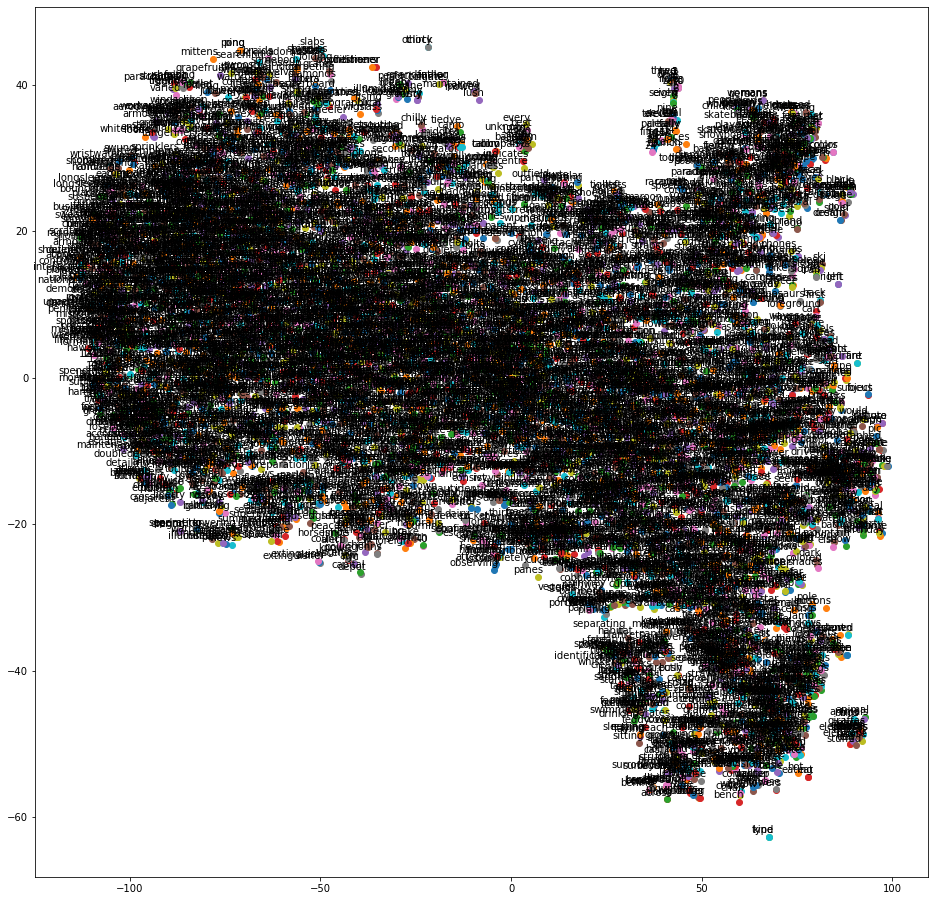

In [22]:
tsne_plot(model)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5192 samples in 0.076s...
[t-SNE] Computed neighbors for 5192 samples in 4.720s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5192
[t-SNE] Computed conditional probabilities for sample 2000 / 5192
[t-SNE] Computed conditional probabilities for sample 3000 / 5192
[t-SNE] Computed conditional probabilities for sample 4000 / 5192
[t-SNE] Computed conditional probabilities for sample 5000 / 5192
[t-SNE] Computed conditional probabilities for sample 5192 / 5192
[t-SNE] Mean sigma: 0.087978
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.393959
[t-SNE] KL divergence after 2500 iterations: 1.987805


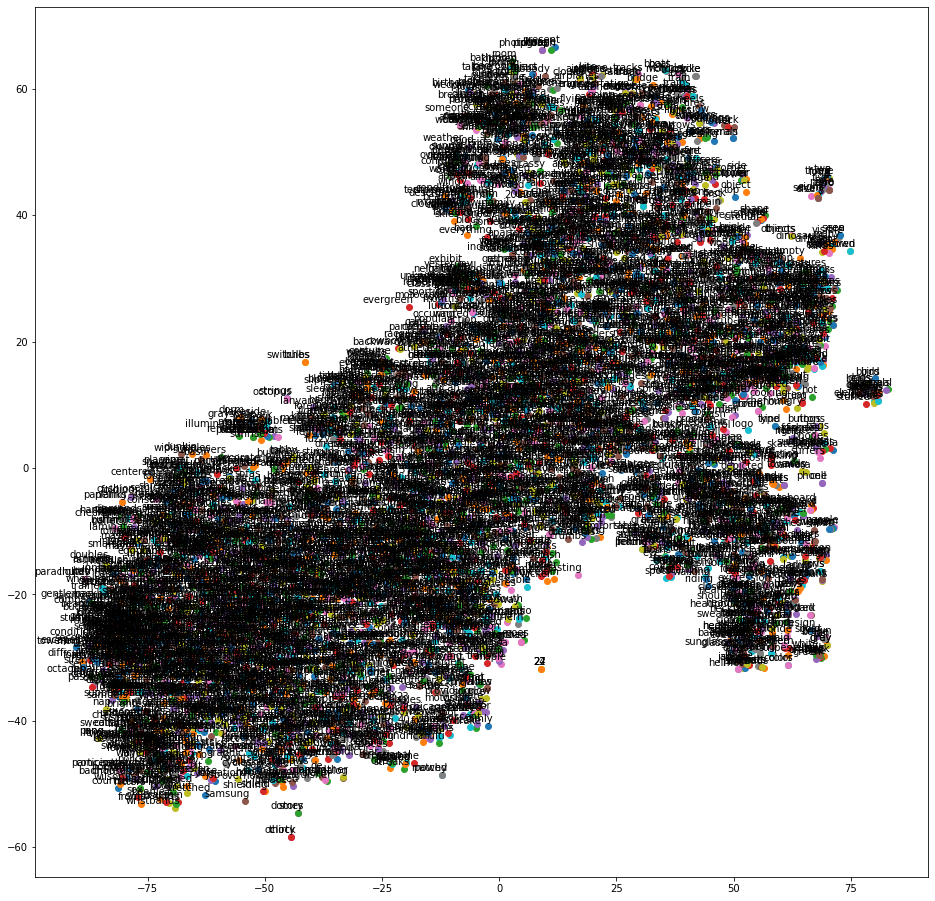

In [23]:
model1 = word2vec.Word2Vec(corpus, window=20, min_count=3, workers=4)
tsne_plot(model1)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 991 samples in 0.010s...
[t-SNE] Computed neighbors for 991 samples in 0.249s...
[t-SNE] Computed conditional probabilities for sample 991 / 991
[t-SNE] Mean sigma: 0.917767
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.752296
[t-SNE] KL divergence after 2500 iterations: 1.189507


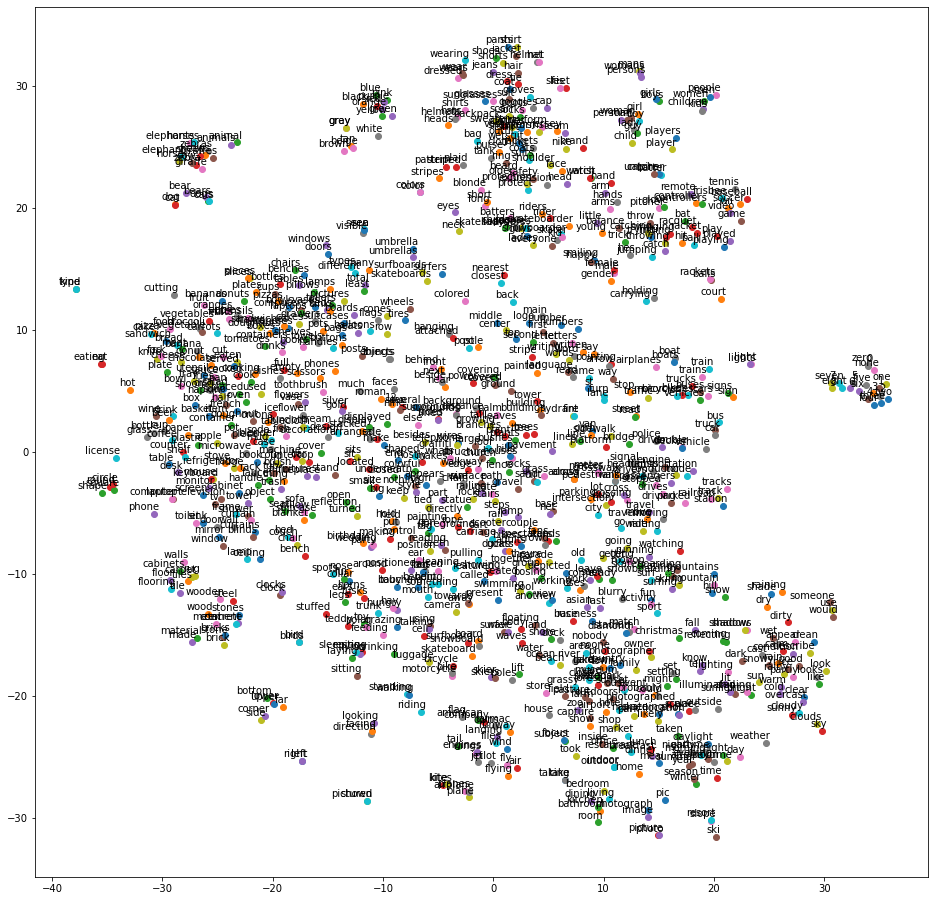

In [24]:
model2 = word2vec.Word2Vec(corpus, window=20, min_count=50, workers=4)
tsne_plot(model2)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 631 samples in 0.004s...
[t-SNE] Computed neighbors for 631 samples in 0.101s...
[t-SNE] Computed conditional probabilities for sample 631 / 631
[t-SNE] Mean sigma: 1.292484
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.099030
[t-SNE] KL divergence after 2500 iterations: 1.009887


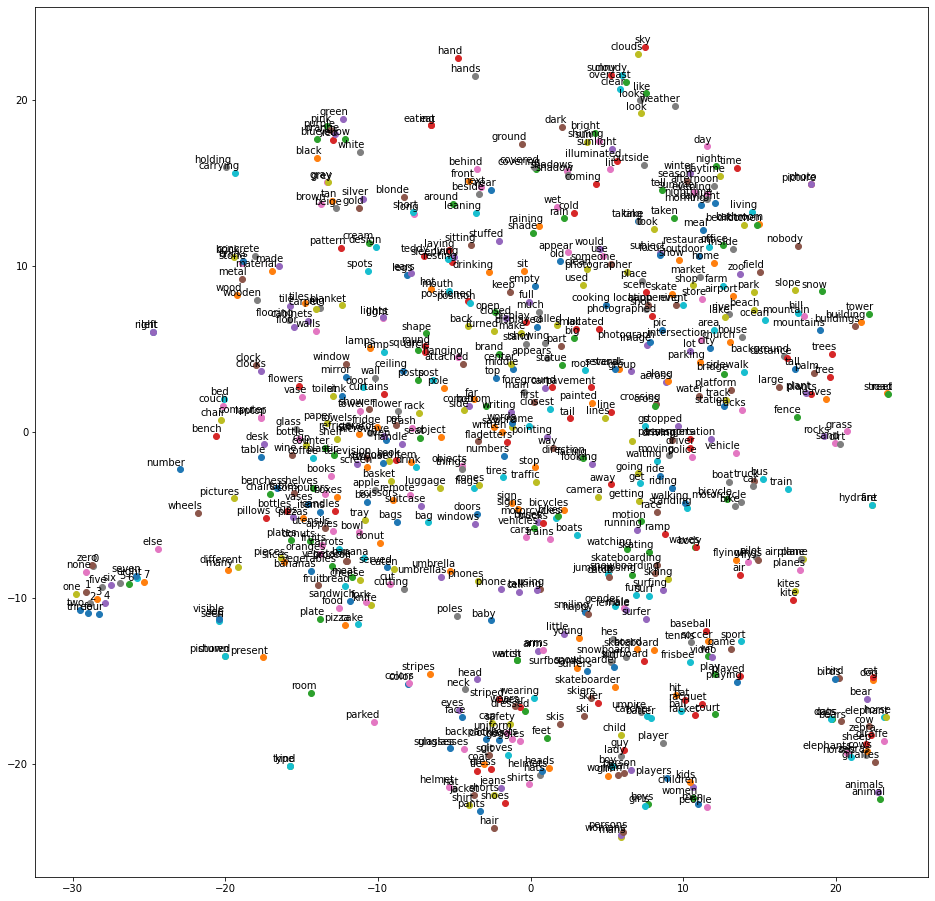

In [25]:
model3 = word2vec.Word2Vec(corpus, window=50, min_count=100, workers=4)
tsne_plot(model3)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 382 samples in 0.002s...
[t-SNE] Computed neighbors for 382 samples in 0.043s...
[t-SNE] Computed conditional probabilities for sample 382 / 382
[t-SNE] Mean sigma: 1.722830
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.450500
[t-SNE] KL divergence after 1500 iterations: 0.833873


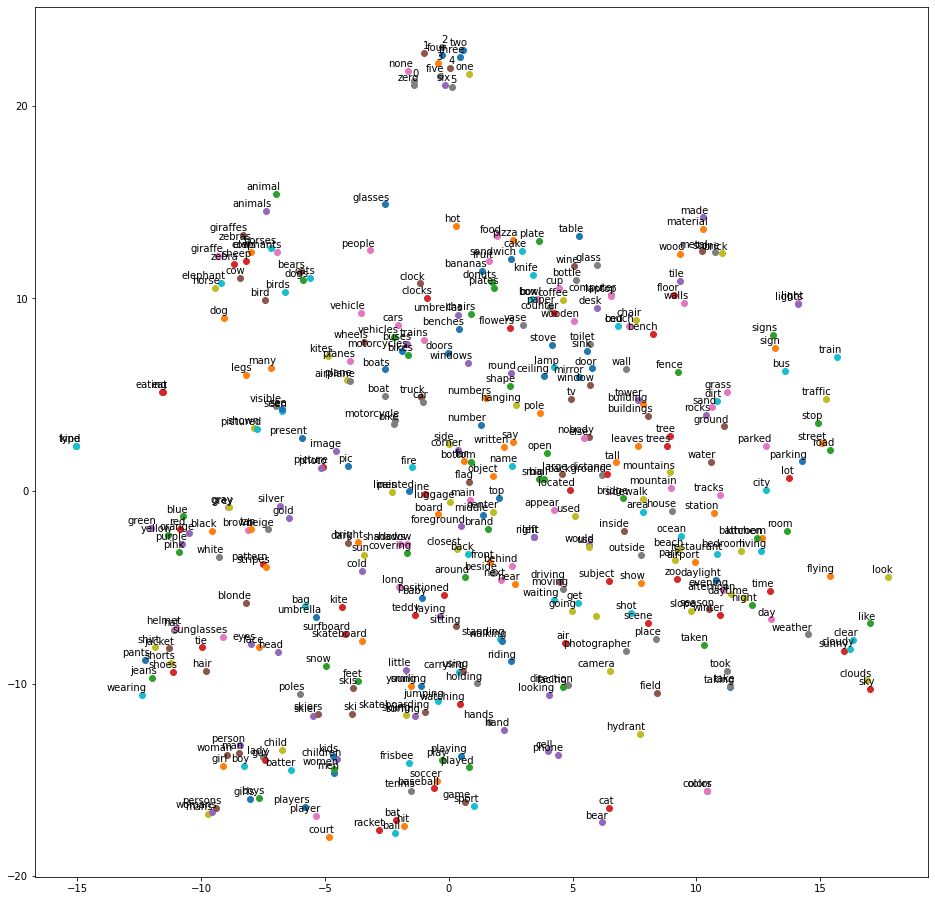

In [26]:
model4 = word2vec.Word2Vec(corpus, window=50, min_count=200, workers=4)
tsne_plot(model4)

In [27]:
len(list(model4.wv.index_to_key))

382

#### Finding 10 most similar words to a word 

In [28]:
model.wv.similar_by_word('man')

[('woman', 0.9502068161964417),
 ('person', 0.9425399899482727),
 ('lady', 0.9349565505981445),
 ('guy', 0.9317010641098022),
 ('boy', 0.9205945730209351),
 ('girl', 0.8919104933738708),
 ('child', 0.8551884293556213),
 ('kid', 0.8517551422119141),
 ('girls', 0.7707337141036987),
 ('skateboarder', 0.7705587148666382)]

In [29]:
model.wv.similar_by_word('woman')

[('lady', 0.9526432752609253),
 ('man', 0.9502068758010864),
 ('girl', 0.932153046131134),
 ('boy', 0.9038507342338562),
 ('person', 0.8950963616371155),
 ('guy', 0.8905283212661743),
 ('child', 0.8745867013931274),
 ('kid', 0.8439620137214661),
 ('girls', 0.777564525604248),
 ('gentleman', 0.7517912983894348)]

In [30]:
model.wv.similar_by_word('doctor')

[('earlier', 0.9072896242141724),
 ('waiter', 0.9060217142105103),
 ('condensation', 0.8977973461151123),
 ('added', 0.897569477558136),
 ('tossing', 0.8966313004493713),
 ('contents', 0.8953098058700562),
 ('wallet', 0.8924827575683594),
 ('picked', 0.8917659521102905),
 ('loud', 0.8917596936225891),
 ('mixed', 0.8913648128509521)]

In [115]:
model.wv.similar_by_word('nurse')

[('patrons', 0.929516613483429),
 ('locked', 0.9245469570159912),
 ('bits', 0.9205870032310486),
 ('elmo', 0.9191575050354004),
 ('apart', 0.9176197648048401),
 ('sleep', 0.9157648086547852),
 ('spread', 0.9146900177001953),
 ('cards', 0.9144390225410461),
 ('speaker', 0.9126657843589783),
 ('wreckage', 0.9113823771476746)]

In [117]:
model.wv.similar_by_word('teacher')

[('elbows', 0.9518066644668579),
 ('age', 0.946098804473877),
 ('zoom', 0.9403278231620789),
 ('wheelchair', 0.9355242848396301),
 ('cleaning', 0.9348142743110657),
 ('moved', 0.9323151111602783),
 ('funny', 0.9321917295455933),
 ('scratching', 0.9320440888404846),
 ('communicate', 0.9315555095672607),
 ('asleep', 0.9312703013420105)]

In [31]:
model.wv.similar_by_word('beauty')

[('ranch', 0.928267240524292),
 ('africa', 0.9247624278068542),
 ('classroom', 0.9242547154426575),
 ('outdoors', 0.9213560223579407),
 ('safari', 0.9164061546325684),
 ('museum', 0.9160587191581726),
 ('nature', 0.9106989502906799),
 ('woods', 0.9085249900817871),
 ('forest', 0.9063165187835693),
 ('airfield', 0.9048615097999573)]

In [32]:
model.wv.similar_by_word('football')

[('tball', 0.9474002718925476),
 ('golf', 0.9310901165008545),
 ('basketball', 0.9283960461616516),
 ('volleyball', 0.9261643290519714),
 ('softball', 0.9147544503211975),
 ('bowling', 0.9080661535263062),
 ('goal', 0.9011993408203125),
 ('nintendo', 0.8999503254890442),
 ('soccer', 0.896665632724762),
 ('represented', 0.8941897749900818)]

In [33]:
model.wv.similar_by_word('africa')

[('nature', 0.9589478969573975),
 ('safari', 0.9573829174041748),
 ('backyard', 0.9560081958770752),
 ('museum', 0.9542470574378967),
 ('classroom', 0.9535437226295471),
 ('wild', 0.9525078535079956),
 ('outdoors', 0.9519760012626648),
 ('bakery', 0.9499006867408752),
 ('ranch', 0.948035478591919),
 ('downtown', 0.945192813873291)]

In [34]:
model.wv.similar_by_word('india')

[('cafeteria', 0.9578275084495544),
 ('desert', 0.9540182948112488),
 ('backyard', 0.9499245882034302),
 ('toronto', 0.9487082362174988),
 ('studio', 0.9483967423439026),
 ('safari', 0.9472464919090271),
 ('remembrance', 0.9424594044685364),
 ('bakery', 0.9420808553695679),
 ('metropolitan', 0.9416601061820984),
 ('festival', 0.9412862658500671)]

In [35]:
model.wv.similar_by_word('flowers')

[('flower', 0.8944497108459473),
 ('vase', 0.8446172475814819),
 ('sunflowers', 0.7923882603645325),
 ('objects', 0.7630458474159241),
 ('things', 0.7618594169616699),
 ('tops', 0.7489596009254456),
 ('trash', 0.7428174018859863),
 ('compared', 0.734357476234436),
 ('cloth', 0.7320061326026917),
 ('vases', 0.7307901382446289)]

In [36]:
model.wv.similar_by_word('banana')

[('donut', 0.9070571660995483),
 ('carrots', 0.9012414813041687),
 ('sandwich', 0.9012070298194885),
 ('bananas', 0.8933436274528503),
 ('fork', 0.892850399017334),
 ('peppers', 0.8876914381980896),
 ('doughnut', 0.887066125869751),
 ('knife', 0.8849534392356873),
 ('shredded', 0.8838859796524048),
 ('vegetable', 0.8749637603759766)]

In [37]:
model.wv.similar_by_word('blonde')

[('ponytail', 0.8759885430335999),
 ('short', 0.8673695921897888),
 ('curly', 0.8671457171440125),
 ('blond', 0.836400032043457),
 ('braids', 0.8253530263900757),
 ('socks', 0.7968176007270813),
 ('facial', 0.7953753471374512),
 ('lefts', 0.7902517318725586),
 ('bangs', 0.7845268249511719),
 ('beanie', 0.7791020274162292)]

In [38]:
model.wv.similar_by_word('bald')

[('beard', 0.9335405826568604),
 ('necklace', 0.9225785136222839),
 ('smile', 0.9196643233299255),
 ('barefoot', 0.9144867062568665),
 ('knee', 0.9041225910186768),
 ('hoodie', 0.9040117859840393),
 ('knees', 0.9029508233070374),
 ('pads', 0.9022988080978394),
 ('apron', 0.9015383720397949),
 ('visor', 0.9012733697891235)]

In [39]:
model.wv.similar_by_word('caucasian')

[('waving', 0.96222323179245),
 ('sex', 0.9584233164787292),
 ('tattoos', 0.9469673037528992),
 ('experienced', 0.9454142451286316),
 ('ethnicity', 0.9426349997520447),
 ('recording', 0.9376203417778015),
 ('barefoot', 0.9370854496955872),
 ('younger', 0.9315677285194397),
 ('picking', 0.9306324124336243),
 ('typing', 0.9304988980293274)]

In [118]:
model.wv.similar_by_word('american')

[('british', 0.9042479991912842),
 ('united', 0.8928493857383728),
 ('lufthansa', 0.8915563225746155),
 ('symbol', 0.8909477591514587),
 ('us', 0.8908280730247498),
 ('usa', 0.8843708634376526),
 ('states', 0.8816438913345337),
 ('airways', 0.8812018036842346),
 ('company', 0.880856990814209),
 ('countrys', 0.879324197769165)]

In [119]:
model.wv.similar_by_word('asian')

[('school', 0.9134386777877808),
 ('pay', 0.8858879804611206),
 ('arizona', 0.8786807060241699),
 ('supposed', 0.877539336681366),
 ('period', 0.8741717338562012),
 ('alert', 0.873962938785553),
 ('drug', 0.8715317845344543),
 ('money', 0.8706196546554565),
 ('n', 0.8651841878890991),
 ('arena', 0.8644693493843079)]

In [120]:
model.wv.similar_by_word('african')

[('sheared', 0.9391645193099976),
 ('handling', 0.9366196393966675),
 ('claws', 0.9359487891197205),
 ('tusk', 0.9356474280357361),
 ('canine', 0.9323810935020447),
 ('wool', 0.9320326447486877),
 ('dust', 0.9320144057273865),
 ('later', 0.9311137795448303),
 ('sometimes', 0.9309897422790527),
 ('bigger', 0.9294945597648621)]

In [129]:
model.wv.similar_by_word('drug')

[('zone', 0.9525130391120911),
 ('ad', 0.9186358451843262),
 ('rc', 0.9134944081306458),
 ('ave', 0.9091766476631165),
 ('text', 0.9083305597305298),
 ('speed', 0.9062073826789856),
 ('mean', 0.9057870507240295),
 ('supposed', 0.9045319557189941),
 ('period', 0.9040929675102234),
 ('san', 0.9023967385292053)]

In [142]:
model.wv.similar_by_word('play')

[('playing', 0.8997613787651062),
 ('video', 0.8888827562332153),
 ('nintendo', 0.8860260248184204),
 ('controllers', 0.8815905451774597),
 ('controller', 0.8802775740623474),
 ('catch', 0.8757131695747375),
 ('trying', 0.8701671361923218),
 ('throwing', 0.8664862513542175),
 ('games', 0.8636894822120667),
 ('game', 0.854434072971344)]

# Visualizing the language modality in the GQA Dataset using Word2vec 

In [40]:
f = open('val_balanced_questions.json')
data = json.load(f)

In [41]:
data

{'05515938': {'semantic': [{'operation': 'select',
    'dependencies': [],
    'argument': 'bird (329774)'},
   {'operation': 'query', 'dependencies': [0], 'argument': 'name'}],
  'entailed': ['05515937', '05515936', '05515922', '05515921'],
  'equivalent': ['05515938'],
  'question': 'What is this bird called?',
  'imageId': '2405722',
  'isBalanced': True,
  'groups': {'global': 'bird', 'local': '11q-bird'},
  'answer': 'parrot',
  'semanticStr': 'select: bird (329774)->query: name [0]',
  'annotations': {'answer': {'0': '329774'},
   'question': {'3': '329774'},
   'fullAnswer': {'3': '329774'}},
  'types': {'detailed': 'categoryThis',
   'semantic': 'cat',
   'structural': 'query'},
  'fullAnswer': 'This is a parrot.'},
 '17197213': {'semantic': [{'operation': 'select',
    'dependencies': [],
    'argument': 'helmet (3205899)'},
   {'operation': 'filter vposition',
    'dependencies': [0],
    'argument': 'middle'},
   {'operation': 'query', 'dependencies': [1], 'argument': 'color

In [42]:
data['05515938']['question']

'What is this bird called?'

In [43]:
print(len(data))
k=list(data.keys())
Q=[]
A=[]
for i in k:
    Q.append(data[i]['question'])
    A.append(data[i]['fullAnswer'])

132062


In [44]:
qa_dict={}
qa_dict['id']=k
qa_dict['question']=Q
qa_dict['answer']=A

In [45]:
df_gqa = pd.DataFrame(qa_dict)

In [46]:
df_gqa.head(10)

id                                           question  \
0  05515938                          What is this bird called?   
1  17197213  What color is the helmet in the middle of the ...   
2  08223573                Is it an indoors or outdoors scene?   
3  14778715  Are there napkins under the utensil to the lef...   
4  14778714             What is under the utensil on the left?   
5   1231468           Which side of the photo is the knife on?   
6  12143164                            What place is pictured?   
7  12143165                                 Which place is it?   
8  19486857                     What is the woman in front of?   
9  17284200          Do all these people have the same gender?   

                                      answer  
0                          This is a parrot.  
1                  The helmet is light blue.  
2                             It is indoors.  
3  Yes, there is a napkin under the utensil.  
4           The napkin is under the utensil.  
5     The knife is on the left of the image.  
6                             It is a shore.  
7                             It is a shore.  
8       The woman is in front of the statue.  
9         No, they are both male and female.

In [47]:
data = clean_dataframe(df_gqa,'question')
data = clean_dataframe(data,'answer')
data.head(5)

id                   question              answer
0  05515938                bird called              parrot
1  17197213  color helmet middle image   helmet light blue
2  08223573     indoors outdoors scene             indoors
3  14778715  napkins utensil left rice  yes napkin utensil
4  14778714               utensil left      napkin utensil

In [48]:
data["all_Words"]=data['question']+" "+ data["answer"]

In [49]:
corpus = build_corpus(data)
corpus[0:10]

[['bird', 'called', 'parrot'],
 ['color', 'helmet', 'middle', 'image', 'helmet', 'light', 'blue'],
 ['indoors', 'outdoors', 'scene', 'indoors'],
 ['napkins', 'utensil', 'left', 'rice', 'yes', 'napkin', 'utensil'],
 ['utensil', 'left', 'napkin', 'utensil'],
 ['side', 'photo', 'knife', 'knife', 'left', 'image'],
 ['place', 'pictured', 'shore'],
 ['place', 'shore'],
 ['woman', 'front', 'woman', 'front', 'statue'],
 ['people', 'gender', 'male', 'female']]

In [50]:
model = word2vec.Word2Vec(corpus, window=20, min_count=2, workers=4)
model.wv['male']

array([-0.514495  ,  0.04910728, -0.51420206, -0.04559933, -0.27520365,
       -0.32703087,  0.3465647 ,  0.6397805 , -0.6887576 ,  0.01095859,
        0.20435092,  0.21471727, -0.93179756,  0.3167041 , -0.69797164,
       -0.09229546,  0.04085993, -0.2977181 , -0.20587167, -0.12406028,
        0.06689239, -0.1813936 , -0.5127411 ,  0.5524378 ,  0.04278107,
        0.23663981,  0.25770447, -0.5979658 , -0.57379013,  0.15322736,
        0.52091503, -0.05039331, -0.28779256, -0.69671774, -0.26457146,
        0.29388833, -0.1553201 ,  0.44698855,  0.34116772, -0.3671302 ,
        0.6954374 , -0.6048988 , -0.11080488,  0.49090546, -0.21831964,
       -0.07718744, -0.3834008 , -0.03072376,  0.83379847,  0.26657087,
       -0.29009134, -0.36564046,  0.20848475, -0.15802635, -0.06656009,
        0.05584375,  0.18344334,  0.31662357,  0.10203886,  0.3363734 ,
        0.44764614, -0.39811745,  0.04344197, -0.41310486, -0.49265704,
       -0.3220441 ,  0.689624  ,  0.38619387, -0.29257694,  0.09

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2347 samples in 0.030s...
[t-SNE] Computed neighbors for 2347 samples in 1.102s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2347
[t-SNE] Computed conditional probabilities for sample 2000 / 2347
[t-SNE] Computed conditional probabilities for sample 2347 / 2347
[t-SNE] Mean sigma: 0.211125
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.892166
[t-SNE] KL divergence after 2500 iterations: 1.486556


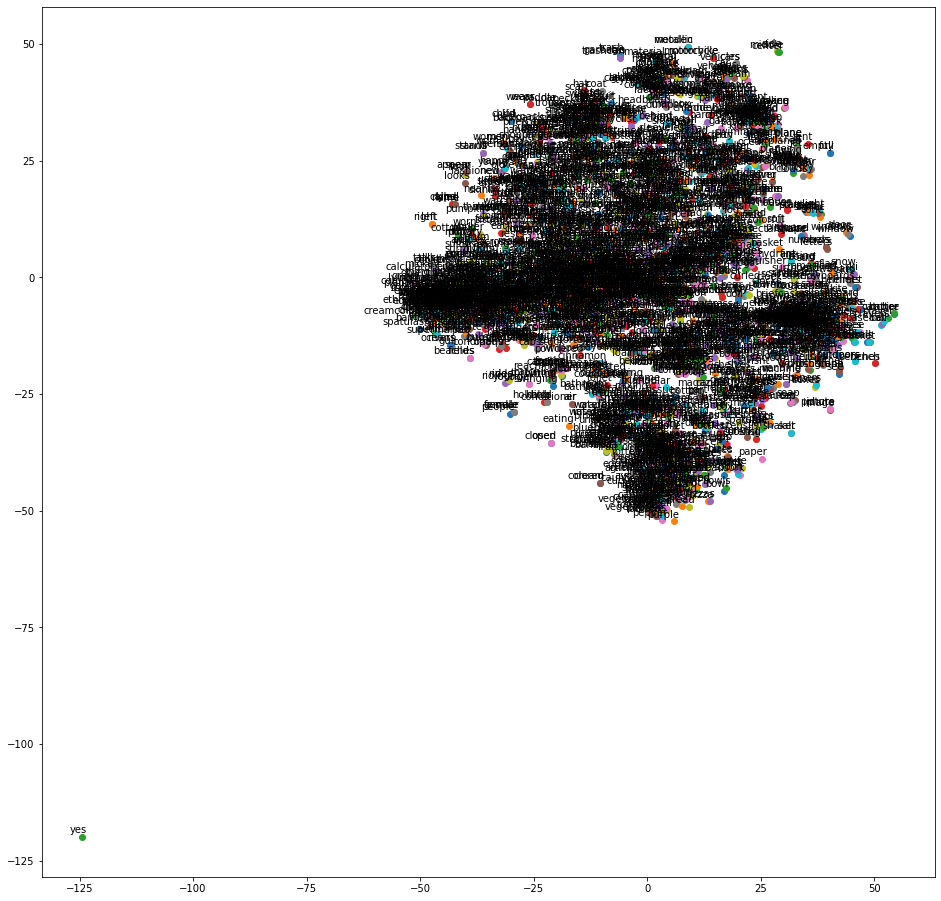

In [51]:
tsne_plot(model)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 722 samples in 0.006s...
[t-SNE] Computed neighbors for 722 samples in 0.138s...
[t-SNE] Computed conditional probabilities for sample 722 / 722
[t-SNE] Mean sigma: 2.461367
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.290100
[t-SNE] KL divergence after 2500 iterations: 1.133323


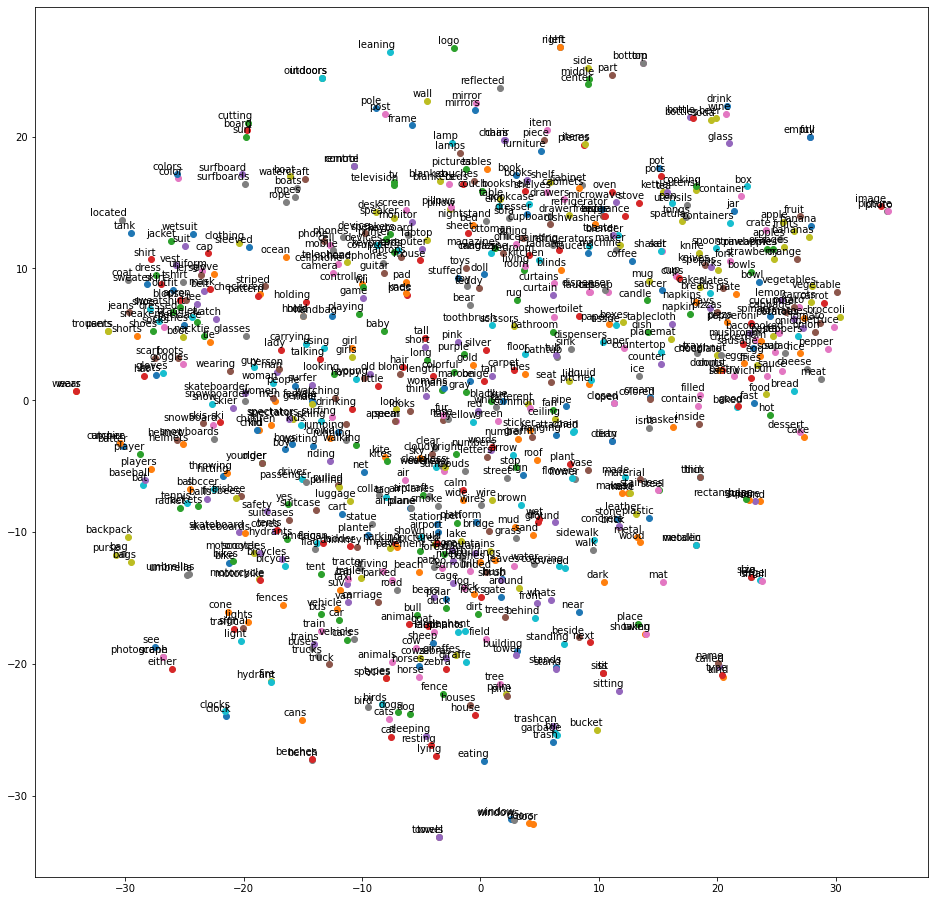

In [52]:
model2 = word2vec.Word2Vec(corpus, window=50, min_count=100, workers=4)
tsne_plot(model2)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 492 samples in 0.004s...
[t-SNE] Computed neighbors for 492 samples in 0.060s...
[t-SNE] Computed conditional probabilities for sample 492 / 492
[t-SNE] Mean sigma: 3.093524
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.581680
[t-SNE] KL divergence after 2500 iterations: 0.988791


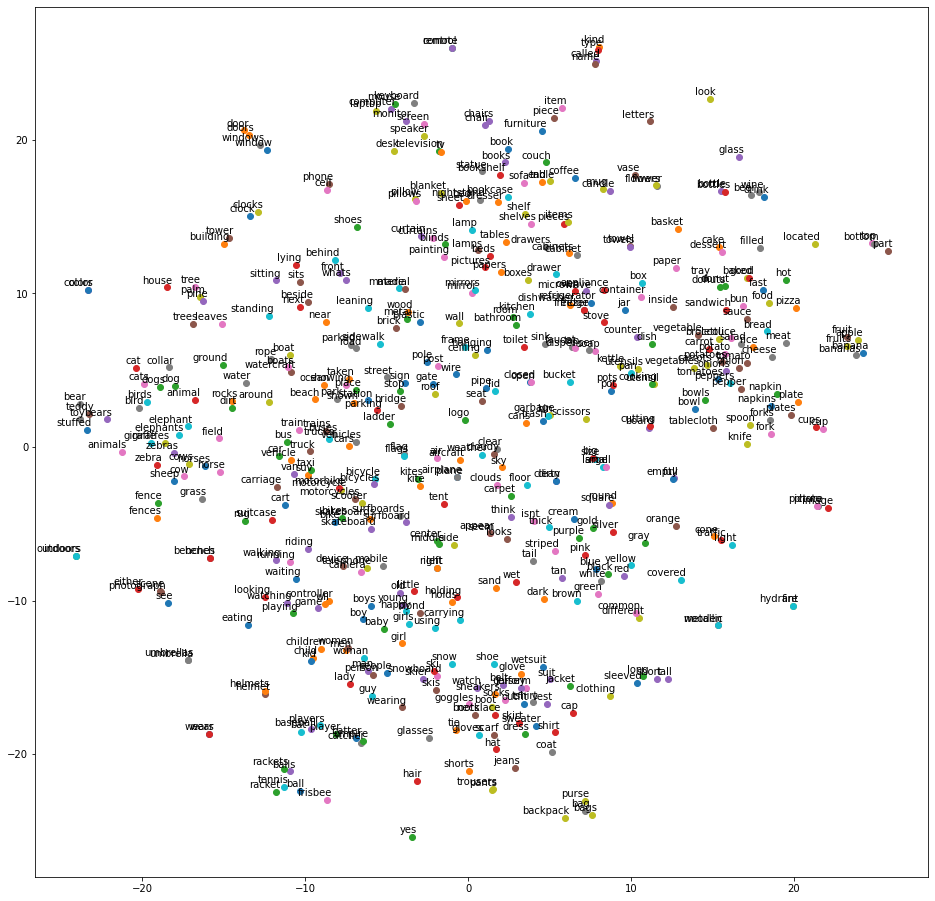

In [53]:
model3 = word2vec.Word2Vec(corpus, window=50, min_count=200, workers=4)
tsne_plot(model3)

In [54]:
new_corp=[]
for i in corpus:
    if 'man' in i:
        new_corp.append(i)
    if 'woman' in i:
        new_corp.append(i)

In [56]:
model.wv.similar_by_word('man')

[('person', 0.7481049299240112),
 ('woman', 0.6928063035011292),
 ('men', 0.6506443619728088),
 ('people', 0.5457084774971008),
 ('boy', 0.5412797927856445),
 ('girl', 0.5222921967506409),
 ('lady', 0.5211814641952515),
 ('happy', 0.49390825629234314),
 ('player', 0.4915730953216553),
 ('wearing', 0.48155149817466736)]

In [57]:
model.wv.similar_by_word('skier')

[('snowboarder', 0.7919929623603821),
 ('snowboard', 0.7083206176757812),
 ('ski', 0.6624482870101929),
 ('skis', 0.6523441672325134),
 ('toddler', 0.61131352186203),
 ('skater', 0.6110103130340576),
 ('skateboarder', 0.6009992957115173),
 ('snow', 0.6009714007377625),
 ('pine', 0.6000083088874817),
 ('umpire', 0.590369462966919)]

In [58]:
model.wv.similar_by_word('flowers')

[('flower', 0.7960411906242371),
 ('daisy', 0.741457998752594),
 ('plant', 0.6582543253898621),
 ('bouquet', 0.6431995034217834),
 ('leaf', 0.6330625414848328),
 ('leaves', 0.6126671433448792),
 ('vase', 0.548943817615509),
 ('sponge', 0.5463915467262268),
 ('rose', 0.5304413437843323),
 ('hedge', 0.5169228315353394)]

In [59]:
model.wv.similar_by_word('caucasian')

[('asian', 0.8372076153755188),
 ('ethnic', 0.7457619905471802),
 ('surfing', 0.7370216846466064),
 ('race', 0.7295646667480469),
 ('skating', 0.7184186577796936),
 ('sad', 0.7045171856880188),
 ('snowpants', 0.7031550407409668),
 ('group', 0.6986391544342041),
 ('bracelets', 0.6953919529914856),
 ('bald', 0.6917721033096313)]

In [60]:
model4.wv.similar_by_word('man')

[('person', 0.6279597282409668),
 ('woman', 0.623232364654541),
 ('yes', 0.5401709079742432),
 ('skateboard', 0.4307563900947571),
 ('ball', 0.41856899857521057),
 ('helmet', 0.3883694112300873),
 ('bike', 0.3799223005771637),
 ('tennis', 0.37402039766311646),
 ('shorts', 0.3685852885246277),
 ('people', 0.35913801193237305)]

In [61]:
model4.wv.similar_by_word('woman')

[('man', 0.6232324242591858),
 ('child', 0.5194008946418762),
 ('yes', 0.48719653487205505),
 ('person', 0.4791928827762604),
 ('glasses', 0.47722890973091125),
 ('chair', 0.4563590884208679),
 ('picture', 0.4496288299560547),
 ('purse', 0.43431565165519714),
 ('bottle', 0.43214383721351624),
 ('women', 0.42552751302719116)]

In [62]:
model.wv.similar_by_word('banana')

[('bananas', 0.7738438248634338),
 ('apple', 0.7194252014160156),
 ('fruit', 0.714291512966156),
 ('pear', 0.6626484394073486),
 ('ripe', 0.6610203385353088),
 ('pineapple', 0.6513358354568481),
 ('apples', 0.6511852145195007),
 ('peach', 0.6475752592086792),
 ('oranges', 0.6378020644187927),
 ('fruits', 0.6265759468078613)]

# Analysing the language modality in OK-VQA dataset using word2vec

In [63]:
f = open('OpenEnded_mscoco_train2014_questions.json')
data = json.load(f)

In [64]:
df_okvqa_q=pd.json_normalize(data['questions'])

In [65]:
df_okvqa_q

image_id                                           question  question_id
0        51606         What is the hairstyle of the blond called?       516065
1        81721    How old do you have to be in canada to do this?       817215
2       480208  Can you guess the place where the man is playing?      4802085
3       570618  Which rail company is named after a town in ne...      5706185
4       478903  Is the boy swimming or doing another water act...      4789035
...        ...                                                ...          ...
9004    328101                        What are the people riding?      3281015
9005    201213  Is this boat in this image moving to the right...      2012135
9006    296374         What is the prominent color in this photo?      2963745
9007     34128      What type of computer is shown in this image?       341285
9008    522741                For what meal is the food consumed?      5227415

[9009 rows x 3 columns]

In [144]:
f2 = open('data/mscoco_train2014_annotations.json')
ans = json.load(f2)

In [67]:
ans["annotations"]

[{'image_id': 51606,
  'answer_type': 'other',
  'question_type': 'four',
  'question_id': 516065,
  'answers': [{'answer_id': 1,
    'raw_answer': 'pony tail',
    'answer_confidence': 'yes',
    'answer': 'pony tail'},
   {'answer_id': 2,
    'raw_answer': 'pony tail',
    'answer_confidence': 'yes',
    'answer': 'pony tail'},
   {'answer_id': 3,
    'raw_answer': 'pony tail',
    'answer_confidence': 'yes',
    'answer': 'pony tail'},
   {'answer_id': 4,
    'raw_answer': 'pony tail',
    'answer_confidence': 'yes',
    'answer': 'pony tail'},
   {'answer_id': 5,
    'raw_answer': 'pony tail',
    'answer_confidence': 'yes',
    'answer': 'pony tail'},
   {'answer_id': 6,
    'raw_answer': 'pony tail',
    'answer_confidence': 'yes',
    'answer': 'pony tail'},
   {'answer_id': 7,
    'raw_answer': 'braid',
    'answer_confidence': 'yes',
    'answer': 'braid'},
   {'answer_id': 8,
    'raw_answer': 'braid',
    'answer_confidence': 'yes',
    'answer': 'braid'},
   {'answer_id': 9

In [68]:
df_okvqa_a=pd.json_normalize(ans["annotations"])

In [69]:
df_okvqa_a

image_id answer_type question_type  question_id  \
0        51606       other          four       516065   
1        81721       other         seven       817215   
2       480208       other          four      4802085   
3       570618       other           one      5706185   
4       478903       other         seven      4789035   
...        ...         ...           ...          ...   
9004    328101       other         eight      3281015   
9005    201213       other          nine      2012135   
9006    296374       other         other      2963745   
9007     34128       other         other       341285   
9008    522741       other          five      5227415   

                                                answers  confidence  
0     [{'answer_id': 1, 'raw_answer': 'pony tail', '...           3  
1     [{'answer_id': 1, 'raw_answer': '18', 'answer_...           5  
2     [{'answer_id': 1, 'raw_answer': 'aspen', 'answ...           2  
3     [{'answer_id': 1, 'raw_answer': 'santa fe', 'a...           2  
4     [{'answer_id': 1, 'raw_answer': 'another activ...           2  
...                                                 ...         ...  
9004  [{'answer_id': 1, 'raw_answer': 'elephants', '...           5  
9005  [{'answer_id': 1, 'raw_answer': 'right', 'answ...           3  
9006  [{'answer_id': 1, 'raw_answer': 'white', 'answ...           3  
9007  [{'answer_id': 1, 'raw_answer': 'desktop', 'an...           3  
9008  [{'answer_id': 1, 'raw_answer': 'breakfast', '...           2  

[9009 rows x 6 columns]

In [70]:
concat_ans=[]
for i in df_okvqa_a['answers']:
    sentence=""
    s=[]
    for j in i:
        if j["raw_answer"] not in s:
            sentence=sentence+j['raw_answer']+" "
        s.append(j["raw_answer"])
    concat_ans.append(sentence)
print(len(concat_ans))


9009


In [71]:
df_okvqa_a['answer']=concat_ans

In [72]:
df_okvqa_a

image_id answer_type question_type  question_id  \
0        51606       other          four       516065   
1        81721       other         seven       817215   
2       480208       other          four      4802085   
3       570618       other           one      5706185   
4       478903       other         seven      4789035   
...        ...         ...           ...          ...   
9004    328101       other         eight      3281015   
9005    201213       other          nine      2012135   
9006    296374       other         other      2963745   
9007     34128       other         other       341285   
9008    522741       other          five      5227415   

                                                answers  confidence  \
0     [{'answer_id': 1, 'raw_answer': 'pony tail', '...           3   
1     [{'answer_id': 1, 'raw_answer': '18', 'answer_...           5   
2     [{'answer_id': 1, 'raw_answer': 'aspen', 'answ...           2   
3     [{'answer_id': 1, 'raw_answer': 'santa fe', 'a...           2   
4     [{'answer_id': 1, 'raw_answer': 'another activ...           2   
...                                                 ...         ...   
9004  [{'answer_id': 1, 'raw_answer': 'elephants', '...           5   
9005  [{'answer_id': 1, 'raw_answer': 'right', 'answ...           3   
9006  [{'answer_id': 1, 'raw_answer': 'white', 'answ...           3   
9007  [{'answer_id': 1, 'raw_answer': 'desktop', 'an...           3   
9008  [{'answer_id': 1, 'raw_answer': 'breakfast', '...           2   

                                              answer  
0                          pony tail braid ponytail   
1                                                18   
2         aspen mountains mountain colorado vale co   
3                santa fe new england bnsf sante fe   
4     another activity wakeboarding fishing surfing   
...                                              ...  
9004                             elephants elephant   
9005                                     right left   
9006                                white black red   
9007                            desktop pc desk top   
9008                         breakfast lunch brunch   

[9009 rows x 7 columns]

In [73]:
df_okvqa=pd.merge(df_okvqa_q, df_okvqa_a, on='question_id')

In [74]:
df_okvqa

image_id_x                                           question  \
0          51606         What is the hairstyle of the blond called?   
1          81721    How old do you have to be in canada to do this?   
2         480208  Can you guess the place where the man is playing?   
3         570618  Which rail company is named after a town in ne...   
4         478903  Is the boy swimming or doing another water act...   
...          ...                                                ...   
9004      328101                        What are the people riding?   
9005      201213  Is this boat in this image moving to the right...   
9006      296374         What is the prominent color in this photo?   
9007       34128      What type of computer is shown in this image?   
9008      522741                For what meal is the food consumed?   

      question_id  image_id_y answer_type question_type  \
0          516065       51606       other          four   
1          817215       81721       other         seven   
2         4802085      480208       other          four   
3         5706185      570618       other           one   
4         4789035      478903       other         seven   
...           ...         ...         ...           ...   
9004      3281015      328101       other         eight   
9005      2012135      201213       other          nine   
9006      2963745      296374       other         other   
9007       341285       34128       other         other   
9008      5227415      522741       other          five   

                                                answers  confidence  \
0     [{'answer_id': 1, 'raw_answer': 'pony tail', '...           3   
1     [{'answer_id': 1, 'raw_answer': '18', 'answer_...           5   
2     [{'answer_id': 1, 'raw_answer': 'aspen', 'answ...           2   
3     [{'answer_id': 1, 'raw_answer': 'santa fe', 'a...           2   
4     [{'answer_id': 1, 'raw_answer': 'another activ...           2   
...                                                 ...         ...   
9004  [{'answer_id': 1, 'raw_answer': 'elephants', '...           5   
9005  [{'answer_id': 1, 'raw_answer': 'right', 'answ...           3   
9006  [{'answer_id': 1, 'raw_answer': 'white', 'answ...           3   
9007  [{'answer_id': 1, 'raw_answer': 'desktop', 'an...           3   
9008  [{'answer_id': 1, 'raw_answer': 'breakfast', '...           2   

                                              answer  
0                          pony tail braid ponytail   
1                                                18   
2         aspen mountains mountain colorado vale co   
3                santa fe new england bnsf sante fe   
4     another activity wakeboarding fishing surfing   
...                                              ...  
9004                             elephants elephant   
9005                                     right left   
9006                                white black red   
9007                            desktop pc desk top   
9008                         breakfast lunch brunch   

[9009 rows x 9 columns]

In [75]:
data = clean_dataframe(df_okvqa,'question')
data = clean_dataframe(data,'answer')
data.head(5)

image_id_x                             question  question_id  image_id_y  \
0       51606               hairstyle blond called       516065       51606   
1       81721                           old canada       817215       81721   
2      480208              guess place man playing      4802085      480208   
3      570618   rail company named town new mexico      5706185      570618   
4      478903  boy swimming another water activity      4789035      478903   

  answer_type question_type  \
0       other          four   
1       other         seven   
2       other          four   
3       other           one   
4       other         seven   

                                             answers  confidence  \
0  [{'answer_id': 1, 'raw_answer': 'pony tail', '...           3   
1  [{'answer_id': 1, 'raw_answer': '18', 'answer_...           5   
2  [{'answer_id': 1, 'raw_answer': 'aspen', 'answ...           2   
3  [{'answer_id': 1, 'raw_answer': 'santa fe', 'a...           2   
4  [{'answer_id': 1, 'raw_answer': 'another activ...           2   

                                           answer  
0                       pony tail braid ponytail   
1                                             18   
2      aspen mountains mountain colorado vale co   
3             santa fe new england bnsf sante fe   
4  another activity wakeboarding fishing surfing

In [76]:
data["all_Words"]=data['question']+" "+ data["answer"]

In [77]:
data

image_id_x                             question  question_id  \
0          51606               hairstyle blond called       516065   
1          81721                           old canada       817215   
2         480208              guess place man playing      4802085   
3         570618   rail company named town new mexico      5706185   
4         478903  boy swimming another water activity      4789035   
...          ...                                  ...          ...   
9004      328101                        people riding      3281015   
9005      201213         boat image moving right left      2012135   
9006      296374                prominent color photo      2963745   
9007       34128            type computer shown image       341285   
9008      522741                   meal food consumed      5227415   

      image_id_y answer_type question_type  \
0          51606       other          four   
1          81721       other         seven   
2         480208       other          four   
3         570618       other           one   
4         478903       other         seven   
...          ...         ...           ...   
9004      328101       other         eight   
9005      201213       other          nine   
9006      296374       other         other   
9007       34128       other         other   
9008      522741       other          five   

                                                answers  confidence  \
0     [{'answer_id': 1, 'raw_answer': 'pony tail', '...           3   
1     [{'answer_id': 1, 'raw_answer': '18', 'answer_...           5   
2     [{'answer_id': 1, 'raw_answer': 'aspen', 'answ...           2   
3     [{'answer_id': 1, 'raw_answer': 'santa fe', 'a...           2   
4     [{'answer_id': 1, 'raw_answer': 'another activ...           2   
...                                                 ...         ...   
9004  [{'answer_id': 1, 'raw_answer': 'elephants', '...           5   
9005  [{'answer_id': 1, 'raw_answer': 'right', 'answ...           3   
9006  [{'answer_id': 1, 'raw_answer': 'white', 'answ...           3   
9007  [{'answer_id': 1, 'raw_answer': 'desktop', 'an...           3   
9008  [{'answer_id': 1, 'raw_answer': 'breakfast', '...           2   

                                              answer  \
0                          pony tail braid ponytail    
1                                                18    
2         aspen mountains mountain colorado vale co    
3                santa fe new england bnsf sante fe    
4     another activity wakeboarding fishing surfing    
...                                              ...   
9004                             elephants elephant    
9005                                     right left    
9006                                white black red    
9007                            desktop pc desk top    
9008                         breakfast lunch brunch    

                                              all_Words  
0      hairstyle blond called pony tail braid ponytail   
1                                        old canada 18   
2     guess place man playing aspen mountains mounta...  
3     rail company named town new mexico santa fe ne...  
4     boy swimming another water activity another ac...  
...                                                 ...  
9004                  people riding elephants elephant   
9005           boat image moving right left right left   
9006             prominent color photo white black red   
9007     type computer shown image desktop pc desk top   
9008         meal food consumed breakfast lunch brunch   

[9009 rows x 10 columns]

In [78]:
corpus = build_corpus(data)
corpus[0:10]

[['hairstyle', 'blond', 'called', 'pony', 'tail', 'braid', 'ponytail', ''],
 ['old', 'canada', '18', ''],
 ['guess',
  'place',
  'man',
  'playing',
  'aspen',
  'mountains',
  'mountain',
  'colorado',
  'vale',
  'co',
  ''],
 ['rail',
  'company',
  'named',
  'town',
  'new',
  'mexico',
  'santa',
  'fe',
  'new',
  'england',
  'bnsf',
  'sante',
  'fe',
  ''],
 ['boy',
  'swimming',
  'another',
  'water',
  'activity',
  'another',
  'activity',
  'wakeboarding',
  'fishing',
  'surfing',
  ''],
 ['kids', 'stare', 'curious', 'unusual', 'taught', 'manners', 'scared', ''],
 ['piece',
  'sporting',
  'equipment',
  'invented',
  '1926',
  '1960s',
  '1965',
  'surfboard',
  ''],
 ['officer',
  'using',
  'mode',
  'transportation',
  'patrol',
  'crowd',
  'control',
  'fast',
  'mounted',
  'officer',
  ''],
 ['atypical',
  'look',
  'someone',
  'wearing',
  'makeup',
  'clown',
  'sad',
  'clown',
  'circus',
  ''],
 ['american',
  'president',
  'associated',
  'stuffed',
  '

In [79]:
model = word2vec.Word2Vec(corpus, window=20, min_count=2, workers=4)
model.wv['male']

array([-0.0848458 ,  0.2009465 ,  0.04868323,  0.11218552,  0.05007536,
       -0.26281077,  0.10420631,  0.36462757, -0.25784355, -0.02246588,
       -0.14901645, -0.23256938, -0.02563056,  0.156401  ,  0.00492932,
       -0.16953446,  0.04192449, -0.15153374, -0.02021386, -0.3859644 ,
        0.14238799,  0.03807941,  0.11053587, -0.01842049,  0.0953738 ,
        0.00855025, -0.13059175,  0.05606708, -0.11003305,  0.11217573,
        0.18153511, -0.01542639,  0.03042111, -0.13812414, -0.05933442,
        0.08226889,  0.16995329, -0.2140667 , -0.12780721, -0.36183307,
       -0.01468899, -0.09446529, -0.12282128, -0.04554344,  0.04122748,
       -0.03083615, -0.23333968,  0.04364282,  0.11764324,  0.03329118,
        0.0198721 , -0.09410889, -0.11592378,  0.00338217, -0.10847672,
        0.03875532,  0.18342486, -0.02476575, -0.1273125 ,  0.1478111 ,
        0.00578084,  0.11873613, -0.04462357, -0.04681059, -0.20217691,
        0.22880042,  0.06885839,  0.0990487 , -0.25347063,  0.17

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5489 samples in 0.112s...
[t-SNE] Computed neighbors for 5489 samples in 1.731s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5489
[t-SNE] Computed conditional probabilities for sample 2000 / 5489
[t-SNE] Computed conditional probabilities for sample 3000 / 5489
[t-SNE] Computed conditional probabilities for sample 4000 / 5489
[t-SNE] Computed conditional probabilities for sample 5000 / 5489
[t-SNE] Computed conditional probabilities for sample 5489 / 5489
[t-SNE] Mean sigma: 0.020043
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.225197
[t-SNE] KL divergence after 2500 iterations: 1.469408


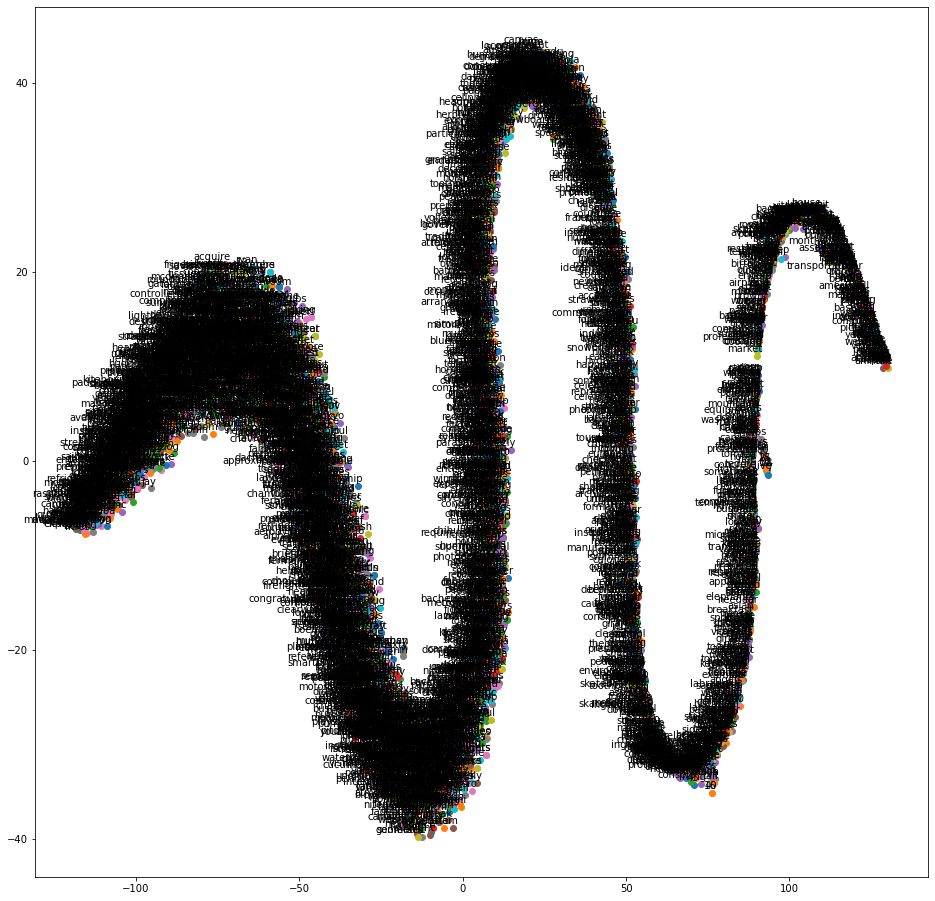

In [80]:
tsne_plot(model)

In [81]:
model2 = word2vec.Word2Vec(new_corp, window=50, min_count=100, workers=4)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 136 samples in 0.000s...
[t-SNE] Computed neighbors for 136 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 136 / 136
[t-SNE] Mean sigma: 1.651795
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.843597
[t-SNE] KL divergence after 1050 iterations: 0.282550


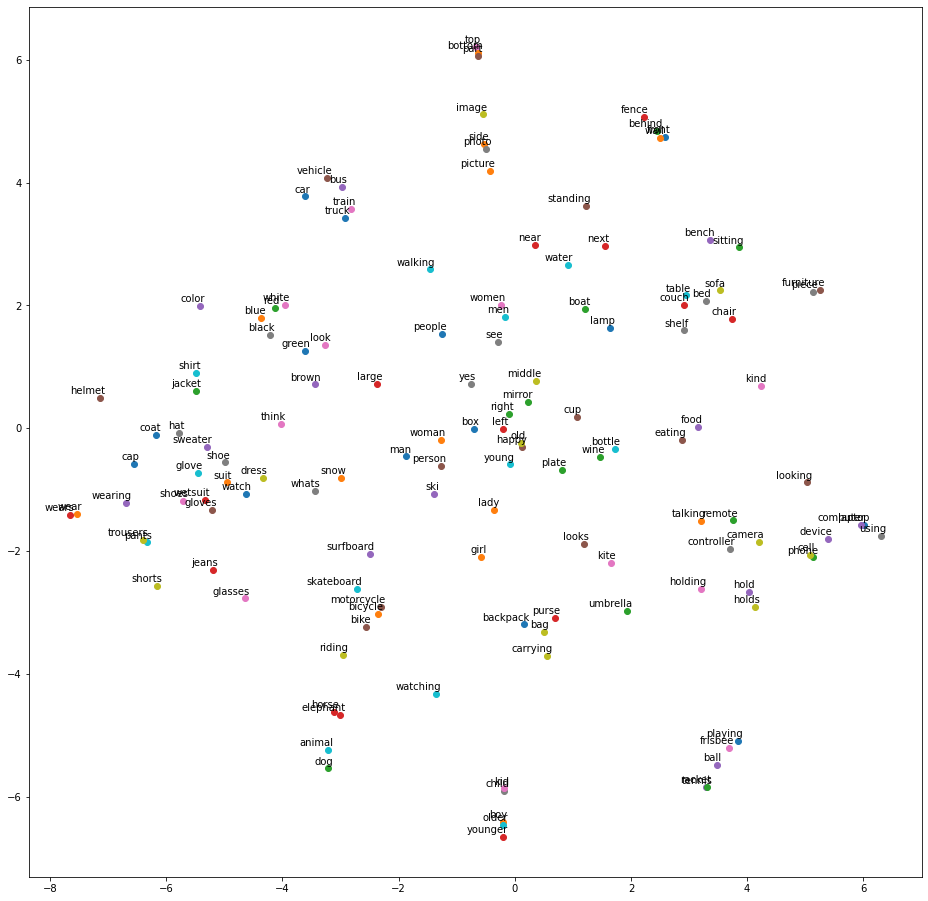

In [82]:
tsne_plot(model2)

In [83]:
model.wv.similar_by_word('man')

[('woman', 0.9998301267623901),
 ('person', 0.9998172521591187),
 ('sport', 0.9998030662536621),
 ('wearing', 0.9998012185096741),
 ('famous', 0.9997888803482056),
 ('using', 0.9997785091400146),
 ('kind', 0.9997778534889221),
 ('first', 0.9997733235359192),
 ('brand', 0.999760627746582),
 ('invented', 0.9997549653053284)]

In [84]:
model.wv.similar_by_word('woman')

[('famous', 0.9998398423194885),
 ('man', 0.9998301267623901),
 ('person', 0.9998139142990112),
 ('behind', 0.9998048543930054),
 ('brand', 0.999802827835083),
 ('invented', 0.9997965097427368),
 ('seen', 0.9997944831848145),
 ('sport', 0.99979168176651),
 ('style', 0.9997910261154175),
 ('work', 0.9997879862785339)]

In [85]:
model.wv.similar_by_word('africa')

[('two', 0.9994673728942871),
 ('get', 0.999447762966156),
 ('usually', 0.9994193315505981),
 ('animals', 0.9994099736213684),
 ('us', 0.9993962645530701),
 ('known', 0.9993855953216553),
 ('need', 0.9993849992752075),
 ('pictured', 0.9993847012519836),
 ('purpose', 0.9993633031845093),
 ('', 0.9993535876274109)]

In [86]:
model.wv.similar_by_word('india')

[('usually', 0.9990490078926086),
 ('two', 0.9990324378013611),
 ('around', 0.9990083575248718),
 ('us', 0.9989907145500183),
 ('vegetables', 0.9989816546440125),
 ('get', 0.998976469039917),
 ('africa', 0.9989637136459351),
 ('purpose', 0.9989603161811829),
 ('likely', 0.9989597797393799),
 ('school', 0.9989575743675232)]

In [87]:
model.wv.similar_by_word('muslim')

[('putting', 0.9764560461044312),
 ('hills', 0.9764324426651001),
 ('svu', 0.9759142398834229),
 ('yankees', 0.9757419228553772),
 ('bedroom', 0.9756319522857666),
 ('bible', 0.9755781292915344),
 ('eyes', 0.9753875136375427),
 ('double', 0.9751884341239929),
 ('signify', 0.9751623868942261),
 ('suits', 0.9751078486442566)]

In [88]:
model.wv.similar_by_word('christian')

[('finger', 0.9921147227287292),
 ('river', 0.9918721914291382),
 ('cold', 0.991844654083252),
 ('umbrella', 0.9918119311332703),
 ('office', 0.9917847514152527),
 ('beach', 0.991756796836853),
 ('sky', 0.9916800260543823),
 ('commercial', 0.9916778802871704),
 ('drink', 0.9916579723358154),
 ('weather', 0.9916484951972961)]

In [89]:
model.wv.similar_by_word('hindu')

[('fry', 0.9963766932487488),
 ('kind', 0.9962862133979797),
 ('flour', 0.9962804317474365),
 ('seem', 0.9962589144706726),
 ('trees', 0.9962377548217773),
 ('picture', 0.9961938858032227),
 ('type', 0.9961829781532288),
 ('sand', 0.9961724877357483),
 ('full', 0.9961454272270203),
 ('photo', 0.9961391687393188)]

In [90]:
model.wv.similar_by_word('doctor')

[('farmers', 0.9878292679786682),
 ('center', 0.9878085255622864),
 ('wetsuit', 0.9876442551612854),
 ('unsafe', 0.987521767616272),
 ('main', 0.9874386787414551),
 ('team', 0.9873940348625183),
 ('call', 0.9873713254928589),
 ('net', 0.9873595237731934),
 ('lines', 0.9873470664024353),
 ('king', 0.987343966960907)]

In [91]:
model.wv.similar_by_word('nurse')

[('earth', 0.948227047920227),
 ('stopping', 0.947934091091156),
 ('wrong', 0.9476179480552673),
 ('u', 0.9475967884063721),
 ('conductor', 0.9475507140159607),
 ('cage', 0.9470454454421997),
 ('jobs', 0.9469265341758728),
 ('danger', 0.9466211199760437),
 ('passenger', 0.9465076923370361),
 ('childrens', 0.9464223980903625)]

In [92]:
model.wv.similar_by_word('grandma')

[('pool', 0.960054337978363),
 ('stroke', 0.9597856998443604),
 ('racket', 0.9577980041503906),
 ('pickup', 0.9576271176338196),
 ('fell', 0.9574616551399231),
 ('ball', 0.9574586749076843),
 ('advertisement', 0.9573991894721985),
 ('forehand', 0.9572293162345886),
 ('sheets', 0.9572226405143738),
 ('carrot', 0.957160234451294)]